In [526]:
# Import necessary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import least_squares
import random

In [393]:
path = Path.cwd() / 'ece661_pics' / 'hw10_image'
np.set_printoptions(precision=5)

In [461]:
class Point():
    '''
        Class for storing point or pixel.
    '''
    def __init__(self, x, y):
        self.x = x  
        self.y = y
        self.point = (int(self.x), int(self.y))

    def adjust_width(self, width):
        x = self.x + width
        return (x, self.y)
    
    def adjust_hieght(self, hieght):
        y = self.y + hieght
        return (self.x, y)

    def multiply_with(self, H):
        x = np.array([self.x, self.y, 1])
        new_x = np.dot(H, x)
        x = new_x[0] / new_x[2]
        y = new_x[1] / new_x[2]
        return (Point(x, y))
    
    def vector(self):
        return np.array([self.x, self.y, 1])

    def __repr__(self):
        return f'({self.x:6.1f},{self.y:6.1f})'

In [462]:
class Pair():
    '''
        Class for stroing corespondance pair.
    '''
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def __repr__(self):
        return f'{self.a}{self.b}'

In [463]:
class Image():
    ''' 
        Class for storing images.
    '''
    
    def __init__(self, path):
        self.path = path   
        self.load() 

    def load(self):
        filename = f'{self.path.parent}\\{self.path.name}'
        self.image = cv.imread(filename)
        self.image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)

    def show(self):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))
    

In [464]:
img_a = Image(path / 'DSC_1603.jpg')
img_b = Image(path / 'DSC_1604.jpg')

In [465]:
def normalize(points):
    '''
        Normalize points. 
    '''
    xs = []
    ys = []
    for point in points:
        xs.append(point.x)
        ys.append(point.y)
    
    xs = np.array(xs)
    ys = np.array(ys)
    mean_x = xs.mean()
    mean_y = ys.mean()
    xs = (xs - mean_x)**2
    ys = (ys - mean_y)**2
    scale = np.sqrt(2) / (np.sqrt((xs + ys)).mean())
    tx = -scale * mean_x
    ty = -scale * mean_y
    T = np.array([
        [scale, 0, tx],
        [0, scale, ty],
        [0, 0, 1]
    ])
    new_points = []
    for point in points:
        new_points.append(point.multiply_with(T))

    return T, new_points


In [466]:
# Manually pick correspondence points
points = [
    # x1 y1 x2 y2
    [785, 115, 826, 63],
    [1648, 56, 1804, 14],
    [1621, 780, 1761, 736],
    [840, 718, 886, 718],
    [544, 775, 593, 795],
    [601, 1275, 655, 1351],
    [1234, 812, 1402, 790],
    [2093, 773, 2151, 701],
    [2045, 1310, 2104, 1210],
    [1248, 1376, 1411, 1365],
    [1964, 714, 1984, 656],
    [2106, 52, 2028, 25]
]
points_a = []
points_b = []
pairs = []
for point in points:
    point_a = Point(point[0], point[1])
    points_a.append(point_a)
    point_b = Point(point[2], point[3])
    points_b.append(point_b)
    pairs.append(Pair(point_a,point_b))    
# Normalize points
T1, points_a_norm = normalize(points_a)
T2, points_b_norm = normalize(points_b)
pairs_norm = [] 
for i in range(len(points)):
    pairs_norm.append(Pair(points_a_norm[i], points_b_norm[i]))

In [467]:
# Construct A matrix for solving AF = 0
A = []
for pair in pairs_norm:
    A.append([
        pair.b.x * pair.a.x,
        pair.b.x * pair.a.y,
        pair.b.x,
        pair.b.y * pair.a.x,
        pair.b.y * pair.a.y,
        pair.b.y,
        pair.a.x,
        pair.a.y,
        1
    ])
A = np.array(A, dtype=np.float)
u, s, vt = np.linalg.svd(A)
# Select the last colume
F = vt.T[:, -1]
F = F.reshape((3, 3))
u, s, vt = np.linalg.svd(F)
# Force last eigen value to 0
s[-1] = 0
F = np.dot(u, np.dot(np.diag(s), vt))
# Denormalize
F = np.dot(T2.T, np.dot(F, T1))
F = F / F[-1, -1]

In [468]:
def compute_camara_params(F):
    '''
     Compute epipoles and camera parameters.
    '''
    # Compute epipoles
    u, s, vt = np.linalg.svd(F)
    e1 = vt.T[:, -1]
    e2 = u[:, -1]
    e1 = e1 / e1[2]
    e2 = e2 / e2[2]
    #Compute camara parameters
    P1 = np.eye(3)
    P1 = np.append(P1, np.zeros((3, 1)), axis=1)
    ex = np.array([
        [0, -e2[2], e2[1]],
        [e2[2], 0, -e2[0]],
        [-e2[1], e2[0], 0]
    ])
    P2 = np.append(np.dot(ex, F), e2.reshape((3, 1)), axis=1)
    return e1, e2, P1, P2

In [469]:
def cost_function(F, pairs):
    '''
        Cost function for LM optimization.
    '''
    F = F.reshape((3, 3))
    e1, e2, P1, P2 = compute_camara_params(F)
    cost_array = []
    for pair in pairs:
        A = np.array([
            pair.a.x*P1[2,:] - P1[0,:],
            pair.a.y*P1[2,:] - P1[1,:],
            pair.b.x*P2[2,:] - P2[0,:],
            pair.b.y*P2[2,:] - P2[1,:]
        ])
        u, s, vt = np.linalg.svd(A)
        X_world = vt.T[:, -1]
        X_world = X_world / np.linalg.norm(X_world)
        P1X = np.dot(P1, X_world)
        P1X = P1X / P1X[-1]
        P2X = np.dot(P2, X_world)
        P2X = P2X / P2X[-1]
        cost = np.linalg.norm(pair.a.vector()-P1X) + np.linalg.norm(pair.b.vector()-P2X)
        cost_array.append(cost)

    return np.array(cost_array)

In [470]:
# LM optimization
res = least_squares(cost_function, F.ravel(), method='lm',
                    args=(pairs, ),
                    max_nfev=5000)
F = res.x
F = F / F[-1]
F = F.reshape((3,3))
u, s, vt = np.linalg.svd(F)
# Force last eigen value to 0
s[-1] = 0
F = np.dot(u, np.dot(np.diag(s), vt))

In [471]:
def compute_homography(F, pairs, img1, img2):

    e1, e2, P1, P2 = compute_camara_params(F)
    h, w = img1.image_gray.shape
    # Compute G
    angle = np.arctan((h/2-e2[1]) / (e2[0]-w/2))
    f = np.cos(angle)*(e2[0]-w/2) - np.sin(angle)*(e2[1]-h/2)
    G = np.eye(3)
    G[2, 0] = -1/f
    # Compute R
    R = np.zeros((3, 3))
    R[0, 0] = np.cos(angle)
    R[0, 1] = -np.sin(angle)
    R[1, 0] = np.sin(angle)
    R[1, 1] = np.cos(angle)
    R[2, 2] = 1
    # Compute T
    T = np.eye(3)
    T[0, 2] = -w/2
    T[1, 2] = -h/2
    # Compute H2
    H2 = np.dot(G, np.dot(R, T))
    center = Point(w/2, h/2)
    center = center.multiply_with(H2)
    T2 = np.eye(3)
    T2[0, 2] = w/2 - center.x
    T2[1, 2] = h/2 - center.y
    H2 = np.dot(T2, H2)
    H2 = H2 / H2 [2, 2]
    # Compute H0
    ex = np.array([
        [0, -e2[2], e2[1]],
        [e2[2], 0, -e2[0]],
        [-e2[1], e2[0], 0]
    ])
    E = np.array([e2, e2, e2]).T
    M = np.dot(ex, F) + E
    H0 = np.dot(H2, M)
    # Compute H1
    A = []
    b = []
    for pair in pairs:
        new_a = pair.a.multiply_with(H0)
        A.append(new_a.vector())
        new_b = pair.b.multiply_with(H2)
        b.append(new_b.vector())
    A = np.array(A)
    b = np.array(b)[:, 0]
    x = np.dot(np.linalg.pinv(A), b)
    HA = np.eye(3)
    HA[0, :] = x
    H1 = np.dot(HA, H0)
    center = Point(w/2, h/2)
    center = center.multiply_with(H1)
    T1 = np.eye(3)
    T1[0, 2] = w/2 - center.x
    T1[1, 2] = h/2 - center.y
    H1 = np.dot(T2, H1)
    H1 = H1 / H1 [2, 2]

    F_rec = np.dot(np.linalg.pinv(H2.T), np.dot(F, np.linalg.pinv(H1)))
    return F_rec, H1, H2

F_rec, H1, H2 = compute_homography(F, pairs, img1, img2)

True

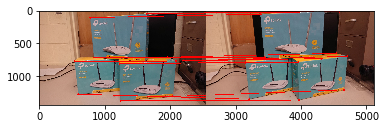

In [479]:
# Draw line for two images
radius = 10
thickness = 10
h, w = img1.image_gray.shape
canvas = cv.hconcat([img_a.image, img_b.image])
for pair in pairs:
    color = (0, 0, 255)
    cv.circle(canvas, pair.a.point, radius, color, thickness)
    cv.circle(canvas, pair.b.adjust_width(w), radius, color, thickness)
    cv.line(canvas, pair.a.point, pair.b.adjust_width(w), color, thickness)
plt.imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
savename = f"{path / 'pic1.png'}"
cv.imwrite(savename, canvas.astype(np.int))

In [492]:
def rectify_image(img, H, points):
    '''
        Compute retified image and points.
    '''
    h, w = img.image_gray.shape
    top_left = Point(0, 0)
    top_right = Point(0, w)
    bot_left = Point(h, 0)
    bot_right = Point(h, w)

    top_left = top_left.multiply_with(H)
    top_right = top_right.multiply_with(H)
    bot_left = bot_left.multiply_with(H)
    bot_right = bot_right.multiply_with(H)

    min_x = np.min([top_left.x, top_right.x, bot_left.x, bot_right.x])
    max_x = np.max([top_left.x, top_right.x, bot_left.x, bot_right.x])
    min_y = np.min([top_left.y, top_right.y, bot_left.y, bot_right.y])
    max_y = np.max([top_left.y, top_right.y, bot_left.y, bot_right.y])

    len_x = max_x - min_x
    len_y = max_y - min_y
    
    H = np.linalg.inv(H)
    canvas = np.zeros((int(len_x), int(len_y), 3), dtype=np.uint8)

    for i in range(canvas.shape[1]):
        for j in range(canvas.shape[0]):
            pixel = Point(i+min_x, j+min_y)
            pixel = pixel.multiply_with(H)
            if 0 <= pixel.x < w and 0 <= pixel.y < h:
                canvas[j, i, :] = img.image[int(pixel.y), int(pixel.x), :]

    H_inv = np.linalg.inv(H)
    points_rectified = []
    for point in points:
        point_rectified = point.multiply_with(H_inv)
        x = int(point_rectified.x - min_x)
        y = int(point_rectified.y - min_y)
        points_rectified.append(Point(x, y))
    
    return canvas, points_rectified

img_a_rectifed, points_a_rectified =  rectify_image(img_a, H1, points_a)
img_b_rectifed, points_b_rectified =  rectify_image(img_b, H2, points_b)

In [496]:
pairs_rectified = []
for i in range(len(pairs)):
    pairs_rectified.append(Pair(points_a_rectified[i], points_b_rectified[i]))

True

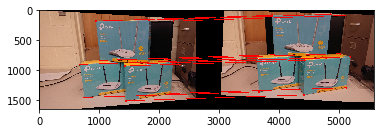

In [571]:
# Draw line for two images after rectified
radius = 10
thickness = 10
color = (0, 0, 255)
h_a, w_a, _ = img_a_rectifed.shape
h_b, w_b, _ = img_b_rectifed.shape
max_h = max(h_a, h_b)
canvas = np.zeros((max_h, w_a+w_b, 3), dtype=np.uint8)
canvas[:h_a, :w_a, :] = img_a_rectifed
canvas[:h_b, w_a:, :] = img_b_rectifed
for pair in pairs_rectified:
    cv.circle(canvas, pair.a.point, radius, color, thickness)
    cv.circle(canvas, pair.b.adjust_width(w_a), radius, color, thickness)
    cv.line(canvas, pair.a.point, pair.b.adjust_width(w_a), color, thickness)
plt.imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
savename = f"{path / 'pic2.png'}"
cv.imwrite(savename, canvas.astype(np.int))

In [508]:
def mark_points(img, points, savename):
    radius = 10
    thickness = 10
    color = (0, 0, 255)
    canvas = img.copy()
    for point in points:
        cv.circle(canvas, point.point, radius, color, thickness)
    filename = f'{path / savename}'
    cv.imwrite(filename, canvas.astype(np.int))
mark_points(img_a.image, points_a, 'pic3.png')
mark_points(img_b.image, points_b, 'pic4.png')
mark_points(img_a_rectifed, points_a_rectified, 'pic5.png')
mark_points(img_b_rectifed, points_b_rectified, 'pic6.png')

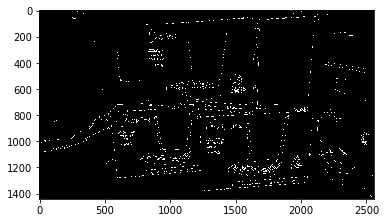

In [527]:
edges_a = cv.Canny(img_a.image, 100, 200)
plt.imshow(edges_a, cmap = 'gray')
filename = f'{path / "pic7.png"}'
cv.imwrite(filename, edges_a.astype(np.uint8))
h, w = edges_a.shape
edge_points_a = []
for i in range(w):
    for j in range(h):
        if edges_a[j, i] == 255:
            edge_points_a.append(Point(i, j))

In [531]:
sample_edges = random.sample(edge_points_a, 40)
mark_points(img_a.image, sample_edges, 'pic8.png')

In [532]:
img_a_rectifed, sample_edges_rectified =  rectify_image(img_a, H1, sample_edges)

In [533]:
mark_points(img_a_rectifed, sample_edges_rectified, 'pic9.png')

In [580]:
def extract_window(image, point, width):
    return image[point.y - width : point.y + width+1, point.x - width : point.x + width+1]

def compute_ncc(img_a, img_b, points_a):
    image_a_gray = cv.cvtColor(img_a, cv.COLOR_BGR2GRAY)
    image_b_gray = cv.cvtColor(img_b, cv.COLOR_BGR2GRAY)
    pairs = []

    # 21 x 21 pixel window. 
    width = 10 # 21 / 2
    for point in points_a:
        ncc_max = 0
        best_candidate = None
        window_a = extract_window(image_a_gray, point, width)
        candidates = []
        h, w = image_b_gray.shape

        for i in range(width, w-width):
            for j in range(point.y-20, point.y+30):
                candidates.append(Point(i, j))

        for candidate in candidates:
            window_b = extract_window(image_b_gray, candidate, width)
            mean_a = np.mean(window_a)
            mean_b = np.mean(window_b)
            window_a_new = window_a - mean_a
            window_b_new = window_b - mean_b
            num = np.sum(window_a_new * window_b_new)
            den = np.sqrt(np.sum(window_a_new**2) * np.sum(window_b_new**2))
            ncc = num / den
            if ncc > ncc_max:
                ncc_max = ncc
                best_candidate = candidate
        if best_candidate is not None:
            pairs.append(Pair(point, best_candidate))

    return pairs

canny_pairs_rectified = compute_ncc(img_a_rectifed, img_b_rectifed, sample_edges_rectified)

True

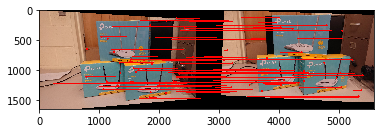

In [582]:
# Draw line for two images after rectified
radius = 10
thickness = 10
color = (0, 0, 255)
h_a, w_a, _ = img_a_rectifed.shape
h_b, w_b, _ = img_b_rectifed.shape
max_h = max(h_a, h_b)
canvas = np.zeros((max_h, w_a+w_b, 3), dtype=np.uint8)
canvas[:h_a, :w_a, :] = img_a_rectifed
canvas[:h_b, w_a:, :] = img_b_rectifed
for pair in canny_pairs_rectified:
    cv.circle(canvas, pair.a.point, radius, color, thickness)
    cv.circle(canvas, pair.b.adjust_width(w_a), radius, color, thickness)
    cv.line(canvas, pair.a.point, pair.b.adjust_width(w_a), color, thickness)
plt.imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
savename = f"{path / 'pic10.png'}"
cv.imwrite(savename, canvas.astype(np.int))